# Inspect the parameters from fitting to the PK2015 idealised runs

Plot:
 - model overview (EKE, coherent ITs)
 - incoherent IT parameters (spatial)
 - example spectra (Lorentzian vs full model)

scatter:

  - eta_m vs tau_D2
  - eta_m vs gamma_D2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from cmocean import cm
import seaborn as sns

import pk2015_utils as utils

import speccy
import nonstat_itides_jax as nsjax
import nonstat_itides as nsit

In [3]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [130]:
def plot_spatial(ds):
    ny, nparams = ds['data'].shape
    paramnames = ds['data'].attrs['parameter names']
    y = ds['nav_lat_vy']/1e3
    
    plt.figure(figsize=(6,nparams*1.2))
    axs=[]
    for ii in range(nparams):
        axs.append(plt.subplot(nparams,1,ii+1))
        axs[ii].plot(y, ds['data'][:,ii],'.')
        axs[ii].set_ylabel(paramnames[ii])
        if ii < nparams-1:
            axs[ii].set_xticklabels([])
    return axs

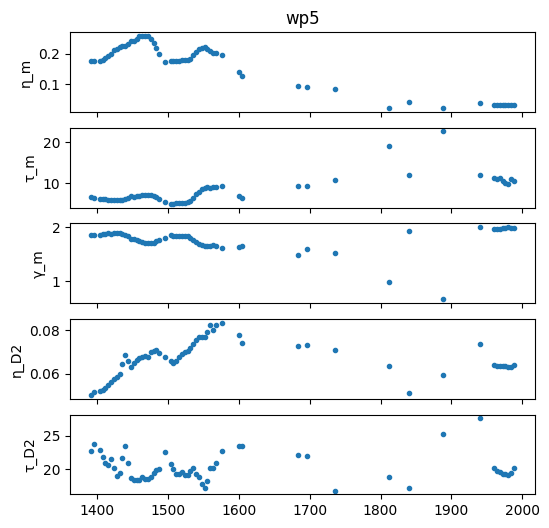

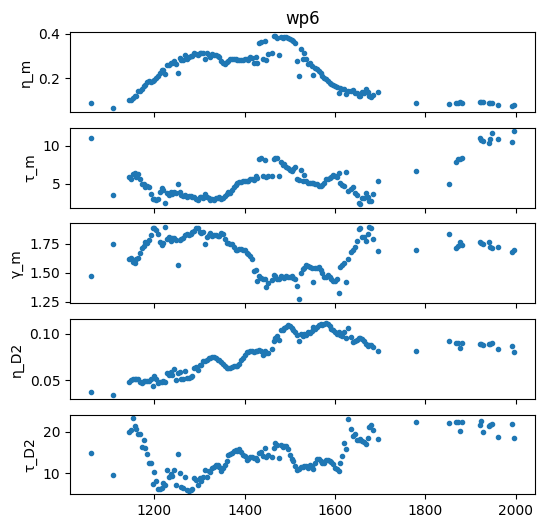

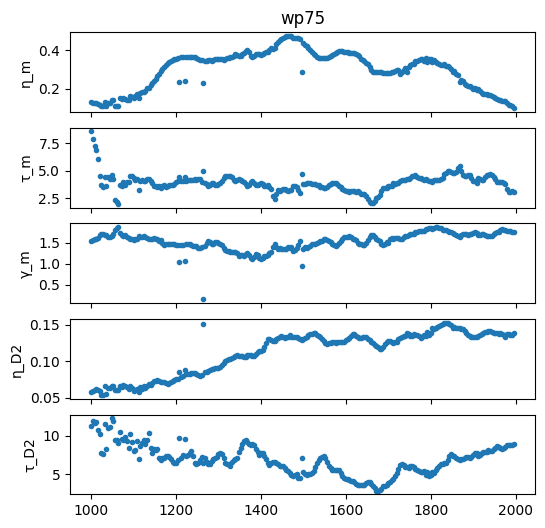

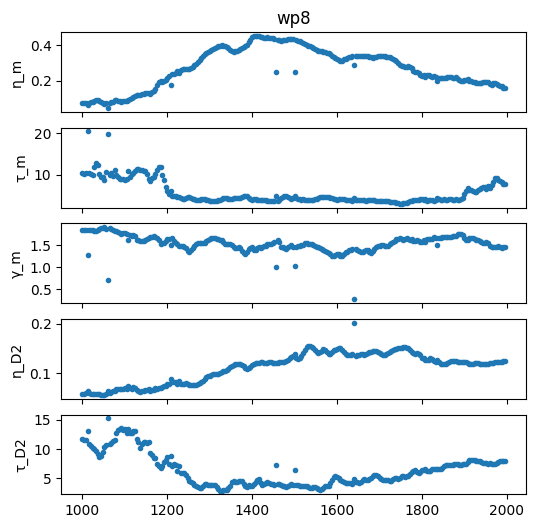

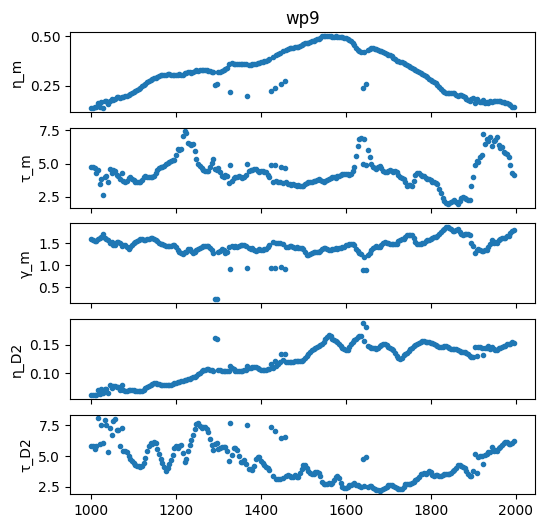

In [131]:
# covfunc = nsjax.itide_D2_meso_gammaexp
covfunc = nsjax.itide_D2_meso_gammaexp_fixed

for scenario in ['wp5','wp6','wp75','wp8','wp9']:
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)
    axs=plot_spatial(ds)
    axs[0].set_title(scenario)

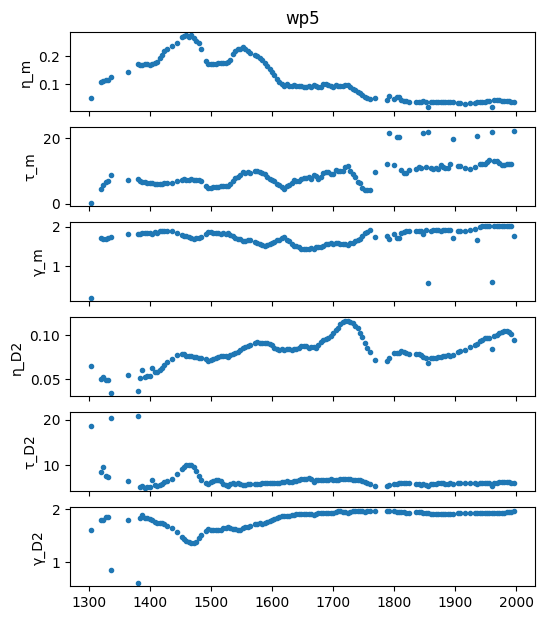

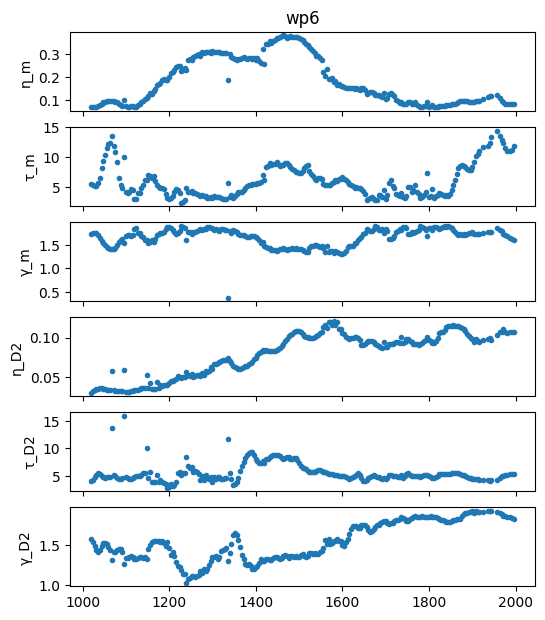

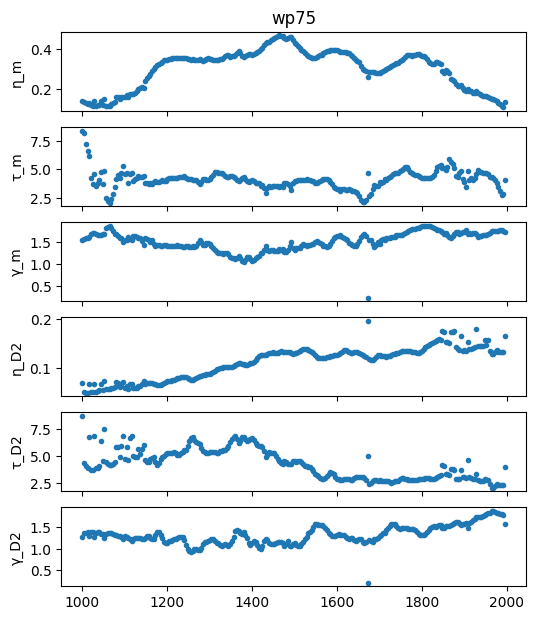

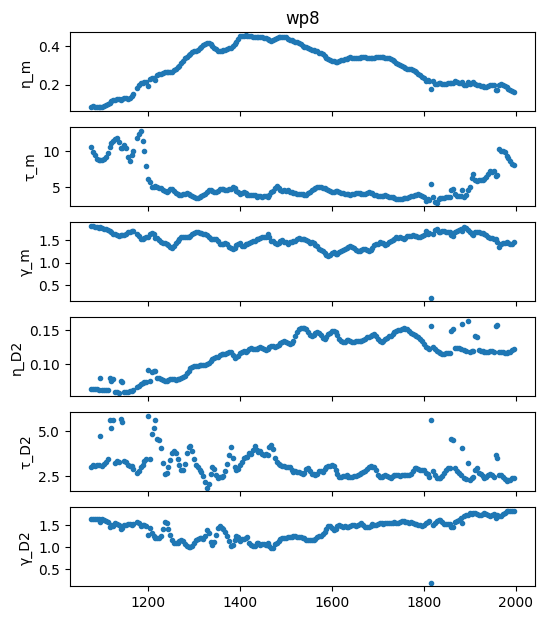

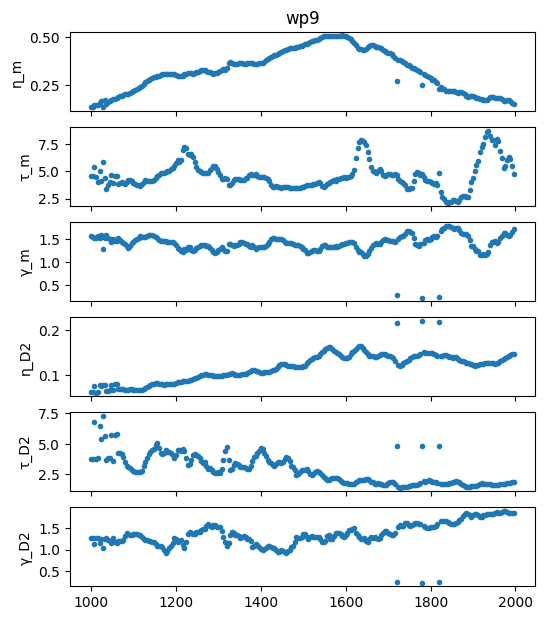

In [132]:
covfunc = nsjax.itide_D2_meso_gammaexp
# covfunc = nsjax.itide_D2_meso_gammaexp_fixed

for scenario in ['wp5','wp6','wp75','wp8','wp9']:
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)
    axs=plot_spatial(ds)
    axs[0].set_title(scenario)

# Scatter plot of eta_m vs tau_D2

Text(0.5, 0, 'η_m')

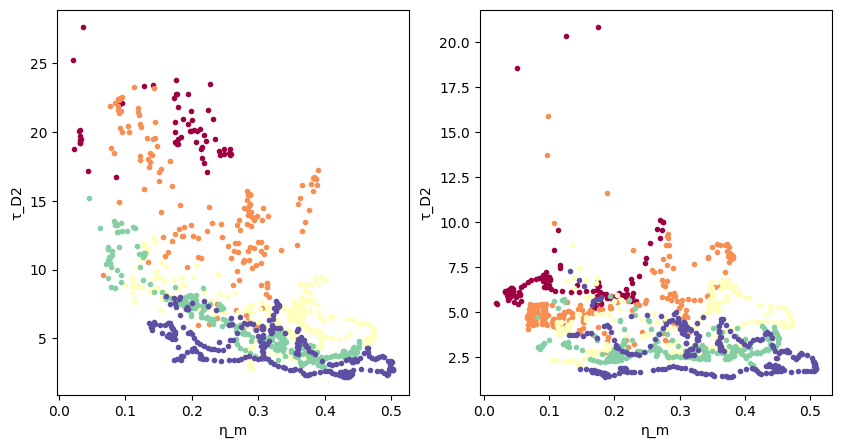

In [65]:
# covfunc = nsjax.itide_D2_meso_gammaexp
cmap = plt.colormaps.get_cmap('Spectral')
colors = [cmap(ii) for ii in np.linspace(0,1,5)]

plt.figure(figsize=(10,5))
ax=plt.subplot(121)
covfunc = nsjax.itide_D2_meso_gammaexp_fixed

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,0], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[0])

ax=plt.subplot(122)
covfunc = nsjax.itide_D2_meso_gammaexp

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,0], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[0])

(1.0, 2.0)

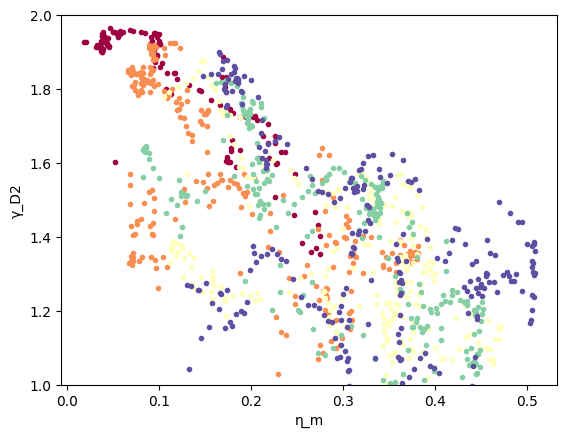

In [69]:
plt.figure()
ax=plt.subplot(111)
covfunc = nsjax.itide_D2_meso_gammaexp

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,0], ds['data'][:,5],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[5])
ax.set_xlabel(paramnames[0])
ax.set_ylim(1,2)

# tau_m vs tau_D2

Text(0.5, 0, 'τ_m')

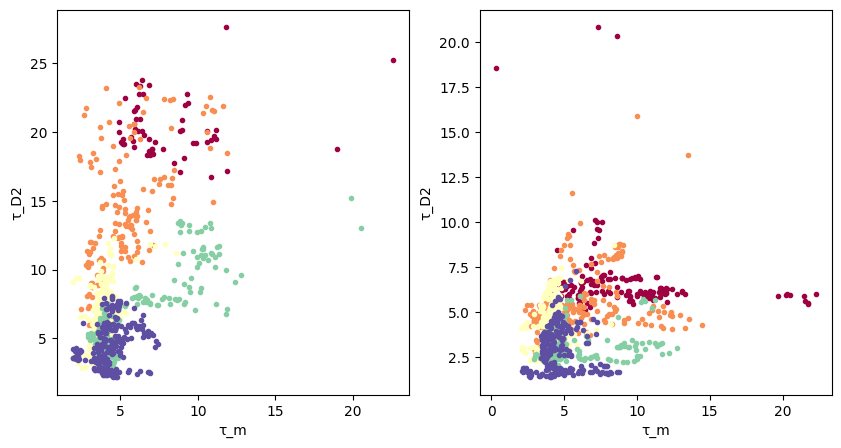

In [70]:
plt.figure(figsize=(10,5))
ax=plt.subplot(121)
covfunc = nsjax.itide_D2_meso_gammaexp_fixed

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,1], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[1])

ax=plt.subplot(122)
covfunc = nsjax.itide_D2_meso_gammaexp

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,1], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[1])

# gamma_m vs tau_D2

Text(0.5, 0, 'γ_m')

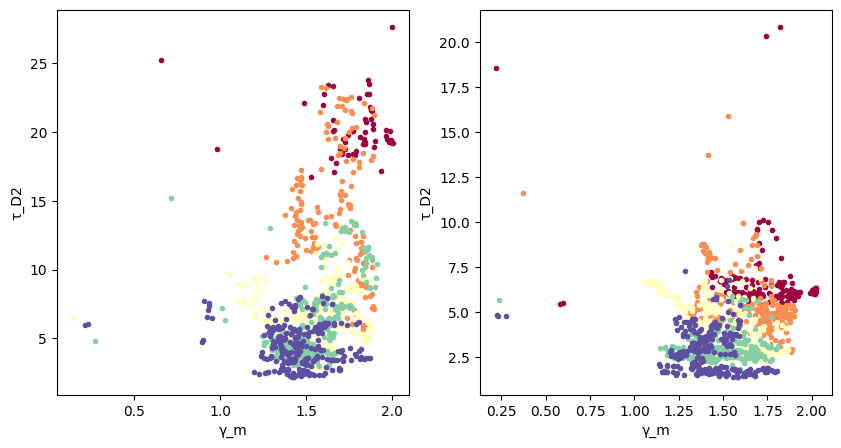

In [71]:
plt.figure(figsize=(10,5))
ax=plt.subplot(121)
covfunc = nsjax.itide_D2_meso_gammaexp_fixed

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,2], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[2])

ax=plt.subplot(122)
covfunc = nsjax.itide_D2_meso_gammaexp

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,2], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[2])

In [118]:
def load_scenario(scenario):
    ncfiles = {'wp5':
             [
             '../DATA/ROMS/wp5/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp5/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010220-00010410.nc'
             ],
               'wp6':
             [
             '../DATA/ROMS/wp6/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp6/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp6/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp6/t2/inst_00010220-00010410.nc',
             ],
               'wp75':
             [
             '../DATA/ROMS/wp75/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp75/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp75/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp75/t2/inst_00010220-00010410.nc',
             ],
                'wp8':
             [
             '../DATA/ROMS/wp8/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp8/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010220-00010410.nc'
             ],
               'wp9':
             [
             '../DATA/ROMS/wp9/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp9/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010220-00010410.nc'
             ],
              }
    
    ds0 = xr.open_mfdataset(ncfiles[scenario][0:2])
    ds1 = xr.open_mfdataset(ncfiles[scenario][2:4])
    
    dt1 = ds0['time_instant'][-1]-ds0['time_instant'][0]
    ds1['time_instant'] = ds1['time_instant']+dt1
    ds1['time_counter'] = ds1['time_counter']+dt1

    if len(ncfiles[scenario])>4:
        ds2 = xr.open_mfdataset(ncfiles[scenario][4:6])
        dt2 = ds1['time_instant'][-1]-ds1['time_instant'][0]
        
        ds2['time_instant'] = ds2['time_instant']+dt1+dt2
        ds2['time_counter'] = ds2['time_counter']+dt1+dt2

        return xr.concat([ds0, ds1, ds2], dim='time_counter')

    else:
        return xr.concat([ds0, ds1], dim='time_counter')
        

In [165]:
def plot_site(ds, dsfull, ypt, c, covfunc, dt, nparams=2):
    dist = np.abs(ds['nav_lat_vy']-ypt).values
    ii = np.argwhere(dist==np.min(dist))[0][0]
    params_pt = ds['data'].isel(y_vy=ii)
    t_ = ds['time_instant'] - ds['time_instant'][0]
    t = t_.values.astype(float)/1e9/86400
    
    acf = covfunc(t, t[0], params_pt.values)

    dist = np.abs(dsfull['nav_lat_vy']-ypt).values
    ii = np.argwhere(dist==np.min(dist))[0][0]
    y = dsfull['v_y'].isel(y_vy=ii).values.squeeze()
    print(y.shape)
    f, I =  nsjax.periodogram(y.squeeze(), delta=dt)
    f_S, S = nsjax.bochner(acf, delta=dt)
    plt.loglog(f, 2*I, 'navy',  lw=0.3)
    plt.loglog(f_S,S,c, ls='--', lw=2)
    ax.set_ylim(1e-7, 10)
    plt.xlim(5e-3, 3)
    plt.xlabel('f [cpd]')
    #plt.plot(t, y[:,0,0])

(9600,)
(9600,)
(9600,)
(9600,)


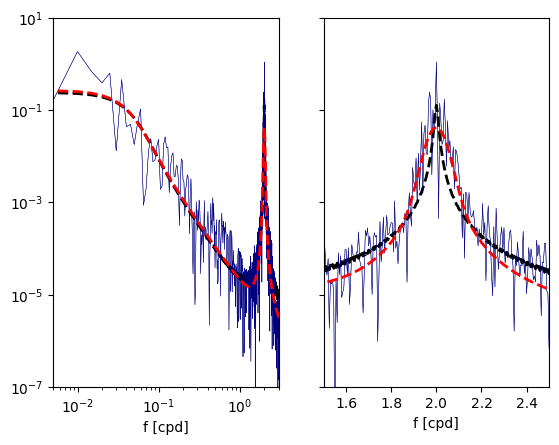

In [183]:
# Highlight the difference between Lorentzian and GammaExp
scenario = 'wp5'
ypt = 1600000.

# scenario = 'wp9'
# ypt = 1600000.

dt = 0.5/24

covfunc = nsjax.itide_D2_meso_gammaexp_fixed
output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
ds = xr.open_dataset(output_nc)

covfunc2 = nsjax.itide_D2_meso_gammaexp
output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc2.__name__)
ds2 = xr.open_dataset(output_nc)

dsfull = load_scenario(scenario)


plt.figure()
ax=plt.subplot(121)
plot_site(ds, dsfull, ypt, 'k', covfunc, dt)
plot_site(ds2, dsfull, ypt, 'r', covfunc2, dt)

ax=plt.subplot(122)
plot_site(ds, dsfull, ypt, 'k', covfunc, dt)
plot_site(ds2, dsfull, ypt, 'r', covfunc2, dt)
ax.set_yticklabels([])
ax.set_xlim(1.5,2.5)
ax.set_xscale('linear')
# plt.legend(('periodogram','Lorentzian','Gamma-Exp'))